In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from xgboost import XGBRegressor
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score
from scipy import stats

In [2]:
def split_data(data):
    y_data=data.iloc[:,-1]
    X_data=data.iloc[:,:-1]
    X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,random_state=100,test_size=0.3)
    return X_train,X_test,y_train,y_test

In [3]:
def get_evaluation_index(y_true,y_predict):
    mae_score=mean_absolute_error(y_true,y_predict)
    rmse_score=math.sqrt(mean_squared_error(y_true,y_predict))
    r2_score_1=r2_score(y_true,y_predict)
    #print("mae_score:%s\nrmse_score:%s\nr2_score:%s"%(mae_score,rmse_score,r2_score_1))
    return mae_score,rmse_score,r2_score_1

In [4]:
#绘制学习曲线
def plot_learning_curve(algo,num,X_train,X_test,y_train,y_test):
    if len(X_train.shape)==1:
        X_train=[[x] for x in X_train]
        X_test=[[x] for x in X_test]
    train_score=[]
    test_score=[]
    for i in range(1,len(X_train)+1):
        if i%10==0:
            algo.fit(X_train[:i],y_train[:i])
            y_train_predict = algo.predict(X_train[:i])
            train_score.append(mean_absolute_error(y_train[:i],y_train_predict))

            y_test_predict=algo.predict(X_test)
            test_score.append(mean_absolute_error(y_test,y_test_predict))
    plt.xlabel("Train num")
    plt.ylabel("mae score")
    plt.title("feature number:%s"%num)
    plt.plot([i for i in range(1,len(train_score)+1)],np.sqrt(train_score),label="train")
    plt.plot([i for i in range(1,len(train_score)+1)],np.sqrt(test_score),label="test")
    plt.legend()
    #指定X轴和y轴的长度，X轴从0到len(X_train)+1,y轴从0到4
    plt.axis([0,len(train_score)+1,0,1])
    plt.show()

In [39]:
def get_train_test_data(all_data):
    train_data=all_data[all_data['type']=='train'].drop(['type'],axis=1)
    test_data=all_data[all_data['type']=='test'].drop(['type','target'],axis=1)
    return train_data,test_data

In [53]:
def split_train_validate_data(train_data,test_size,random_state):
    X=train_data.iloc[:,:-1]
    y=train_data['target']
    X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=test_size,random_state=random_state)
    return X_train,X_validate,y_train,y_validate

In [5]:
#读取数据
data_path='./data/zhengqi_train.txt'
o_data=pd.read_csv(data_path,sep='\t')
#读取测试数据
test_path='./data/zhengqi_test.txt'
test_data=pd.read_csv(test_path,sep='\t')

### 查看测试数据集和训练集的数据分布是否相同，去除掉不同分布的数据特征

d:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


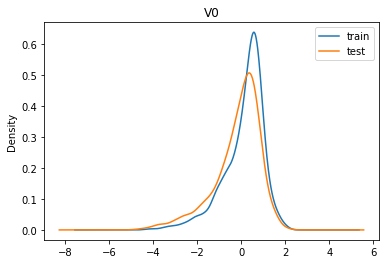

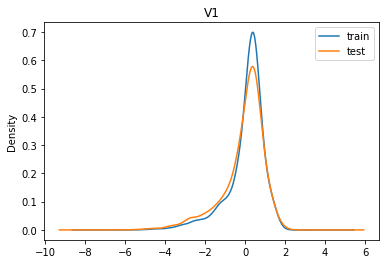

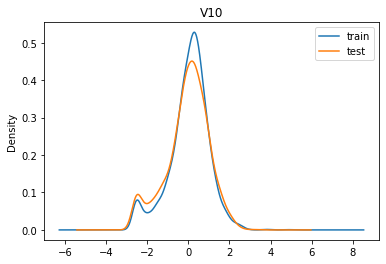

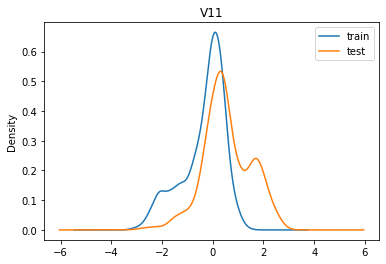

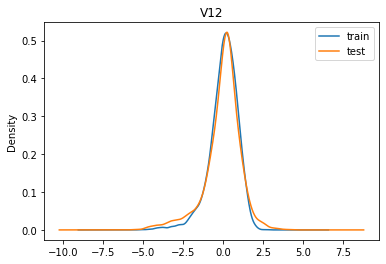

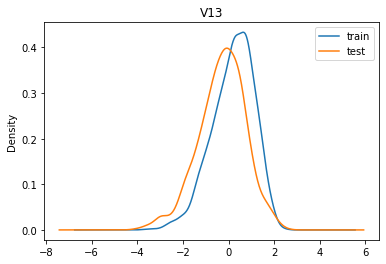

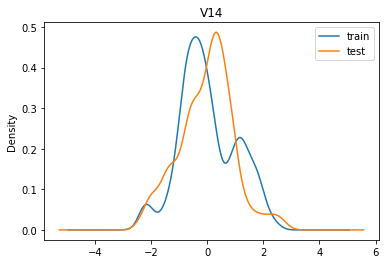

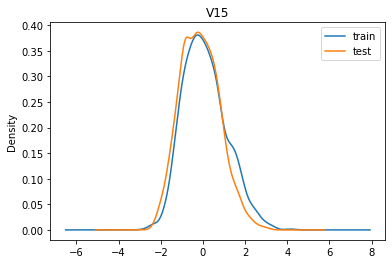

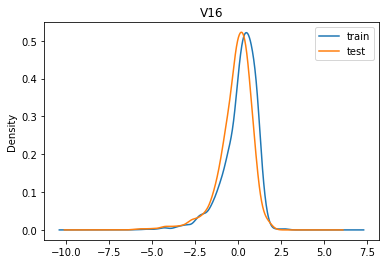

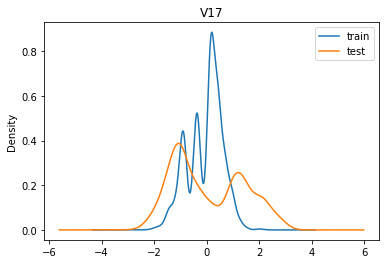

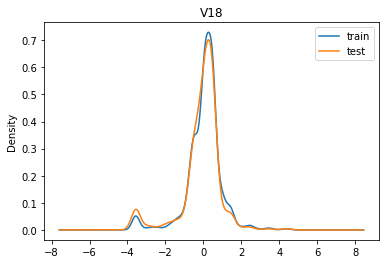

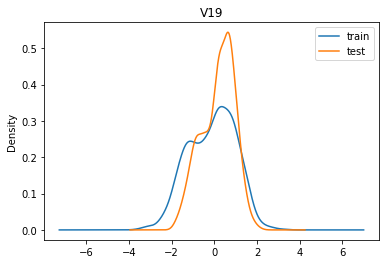

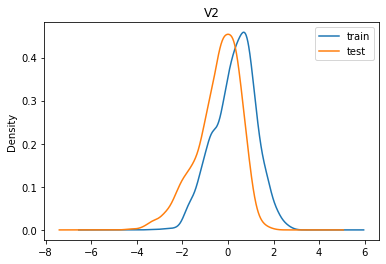

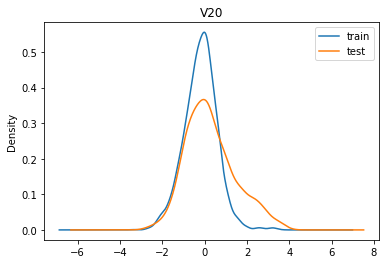

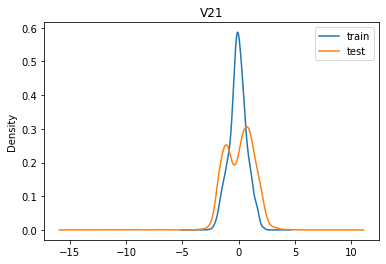

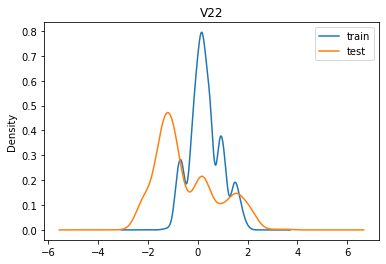

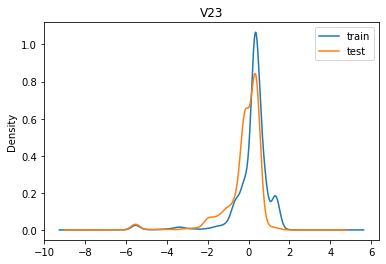

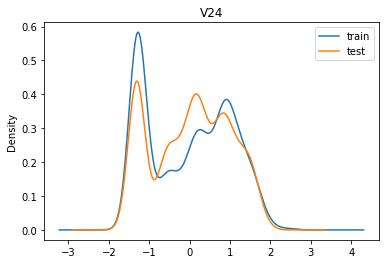

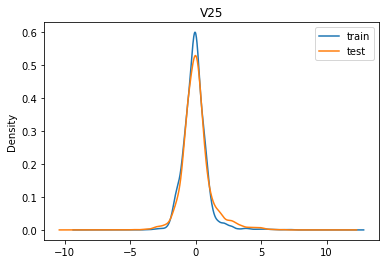

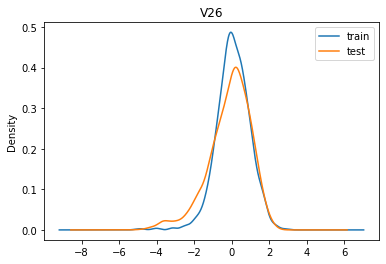

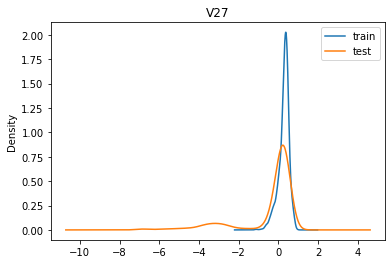

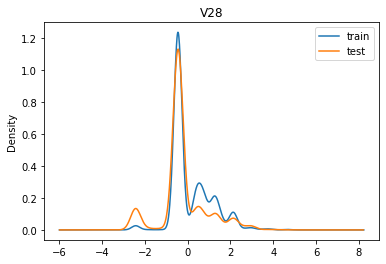

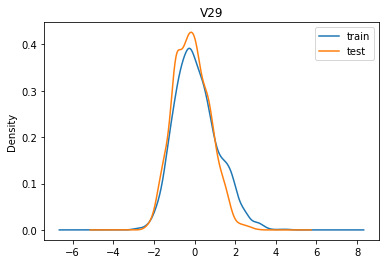

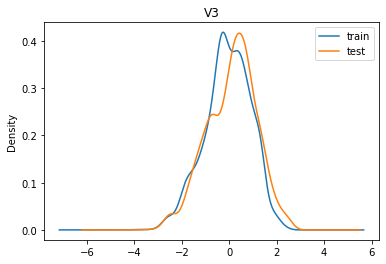

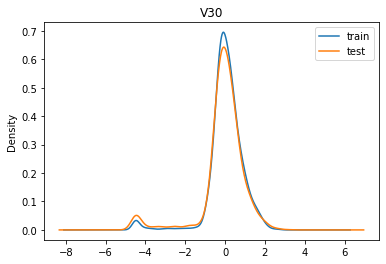

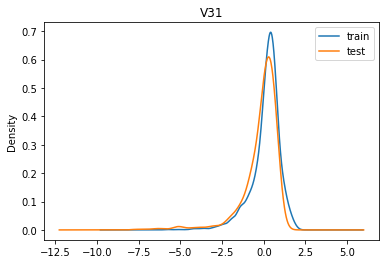

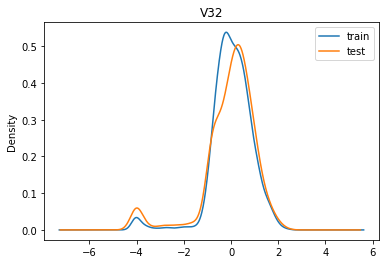

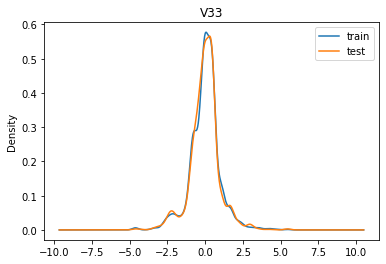

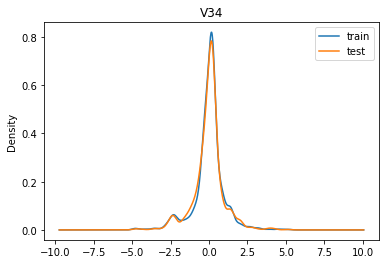

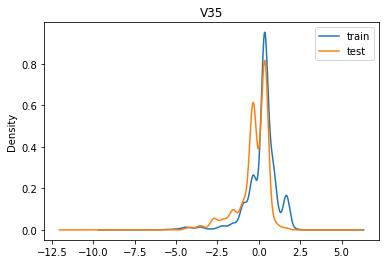

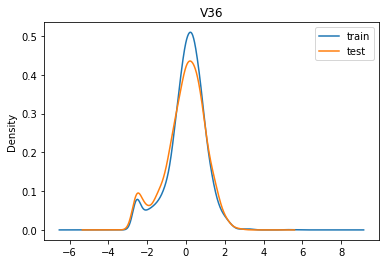

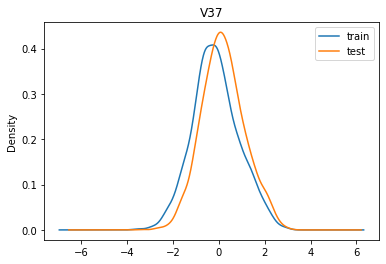

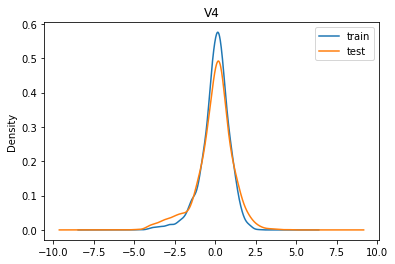

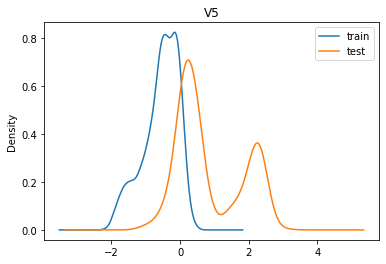

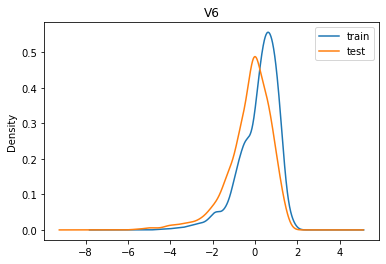

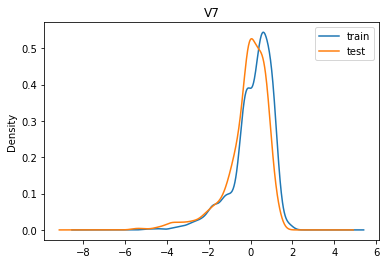

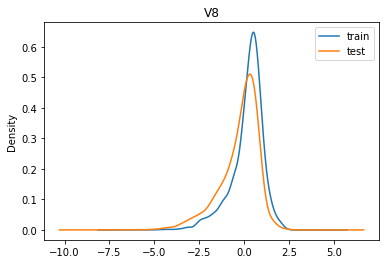

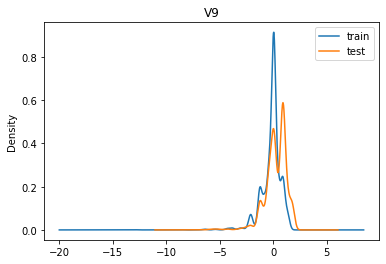

In [75]:
#合并训练集与测试集
o_data['type']='train'
test_data['type']='test'
all_data=pd.concat([o_data,test_data])
#绘制训练集与测试集的分布图
for feature in all_data.columns[:-2]:
    all_data[all_data['type']=='train'][feature].plot(kind='kde')
    all_data[all_data['type']=='test'][feature].plot(kind='kde')
    plt.title(feature)
    plt.legend(['train','test'])
    plt.show()


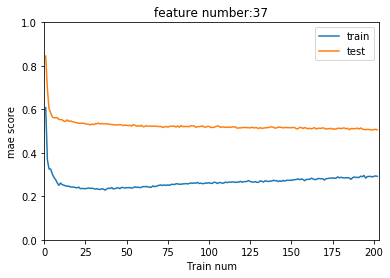

drop feature:['V11']
 mae:0.25704015497930327	 rmse:0.3639954930932604	 r2:0.8559319438690554



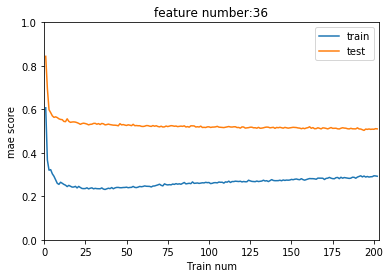

drop feature:['V11', 'V13']
 mae:0.25463421230662653	 rmse:0.36095805032531497	 r2:0.8583263287650281



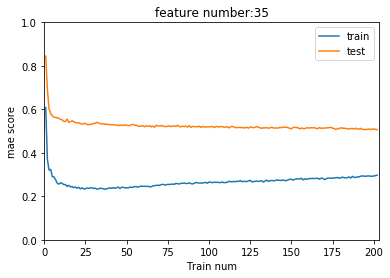

drop feature:['V11', 'V13', 'V14']
 mae:0.2582894501672347	 rmse:0.3684622665288181	 r2:0.8523743842030826



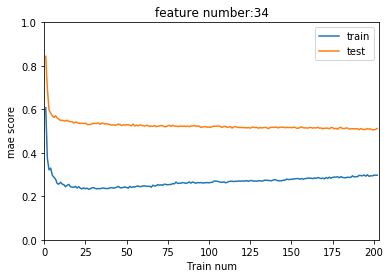

drop feature:['V11', 'V13', 'V14', 'V17']
 mae:0.25742552947310565	 rmse:0.36239572519405006	 r2:0.8571955253343144



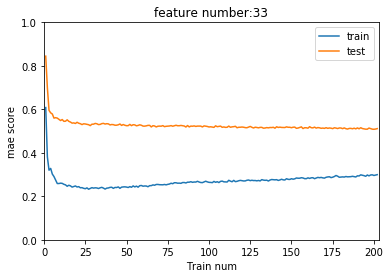

drop feature:['V11', 'V13', 'V14', 'V17', 'V19']
 mae:0.25472590503753123	 rmse:0.3630166879963099	 r2:0.856705716908293



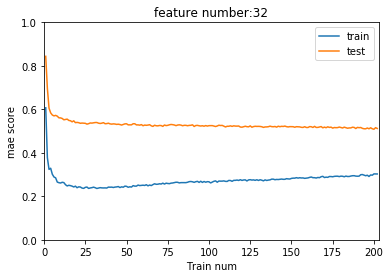

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2']
 mae:0.2628067618631849	 rmse:0.37101119741468347	 r2:0.8503248444923472



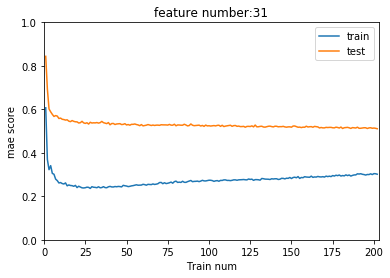

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2', 'V21']
 mae:0.2624401040178957	 rmse:0.36874708338552065	 r2:0.8521460703793527



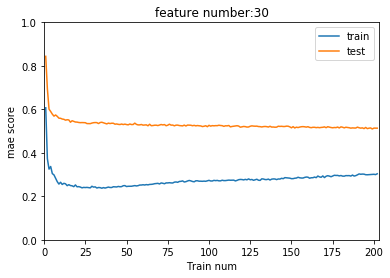

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2', 'V21', 'V35']
 mae:0.26572150799394895	 rmse:0.36943004994682216	 r2:0.8515978745687574



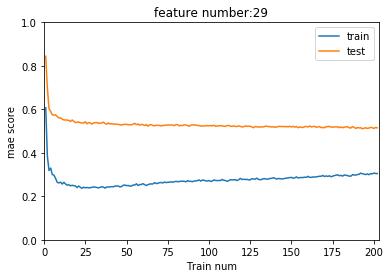

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2', 'V21', 'V35', 'V22']
 mae:0.26702602475874704	 rmse:0.37041768863892266	 r2:0.8508033339027861



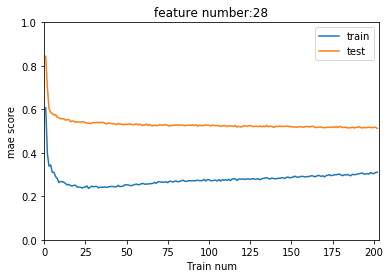

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2', 'V21', 'V35', 'V22', 'V27']
 mae:0.26475189086090184	 rmse:0.37051816098146284	 r2:0.8507223865184175



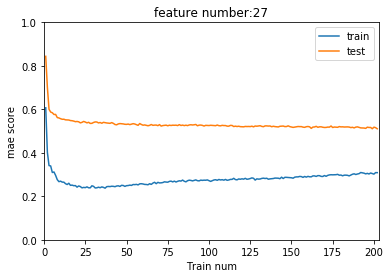

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2', 'V21', 'V35', 'V22', 'V27', 'V5']
 mae:0.26590159576299416	 rmse:0.37372879584182506	 r2:0.8481241201729346



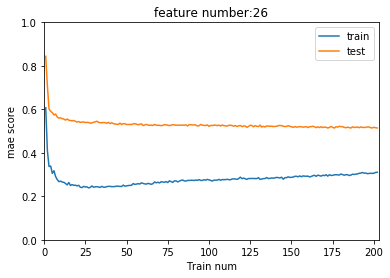

drop feature:['V11', 'V13', 'V14', 'V17', 'V19', 'V2', 'V21', 'V35', 'V22', 'V27', 'V5', 'V9']
 mae:0.26421063964727154	 rmse:0.37162021692376973	 r2:0.84983305391312



In [120]:
#删除掉分布不一样的特征数据 
#通过观察上述分布图发现v11,v13,v14,v17,v19,v2,v21,v35,v22,v27,v5,v9
#删除掉分布不一样的特征，然后对比模型的准确度
#自己挑的：'V11','V13','V14','V17','V19','V2','V21','V35','V22','V27','V5','V9' 提交结果：0.1350
#论坛中的："V5","V9","V11","V17","V22","V28" 提交结果：0.1361
drop_feature_list=['V11','V13','V14','V17','V19','V2','V21','V35','V22','V27','V5','V9']
add_drop_feature=[]
for drop_feature in drop_feature_list:
    add_drop_feature.append(drop_feature)
    all_data_drop=all_data.drop(labels=add_drop_feature,axis=1)
    train_data_drop=all_data_drop[all_data_drop['type']=='train'].drop(labels=['type'],axis=1)
    X_train,X_test,y_train,y_test=split_data(train_data_drop)
    xgb_reg=XGBRegressor(max_depth=8,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
    xgb_reg.fit(X_train,y_train)
    y_predict=xgb_reg.predict(X_test)
    mae_score,rmse_score,r2_score_1=get_evaluation_index(y_test,y_predict)
    plot_learning_curve(xgb_reg,len(X_train.columns),X_train,X_test,y_train,y_test)
    print("drop feature:%s\n mae:%s\t rmse:%s\t r2:%s\n"%([feature for feature in add_drop_feature],mae_score,rmse_score,r2_score_1))

In [122]:
#保存drop_feature之后的结果
all_data_drop.to_csv('./re/all_data_drop.txt',header=True,index=False)

In [6]:
all_data_drop_1=pd.read_csv('./re/all_data_drop.txt')

In [119]:
test_data_drop=all_data_drop[all_data_drop['type']=='test'].drop(['type','target'],axis=1)
y_predict=xgb_reg.predict(test_data_drop)
y_predict_df=pd.DataFrame(y_predict)
y_predict_df.to_csv('./re/y_predict_1.txt',header=False,index=False)

### 通过皮尔逊相关系数 去掉相关性弱的特征

In [7]:
train_data=all_data_drop_1[all_data_drop_1['type']=='train'].drop(['type'],axis=1)

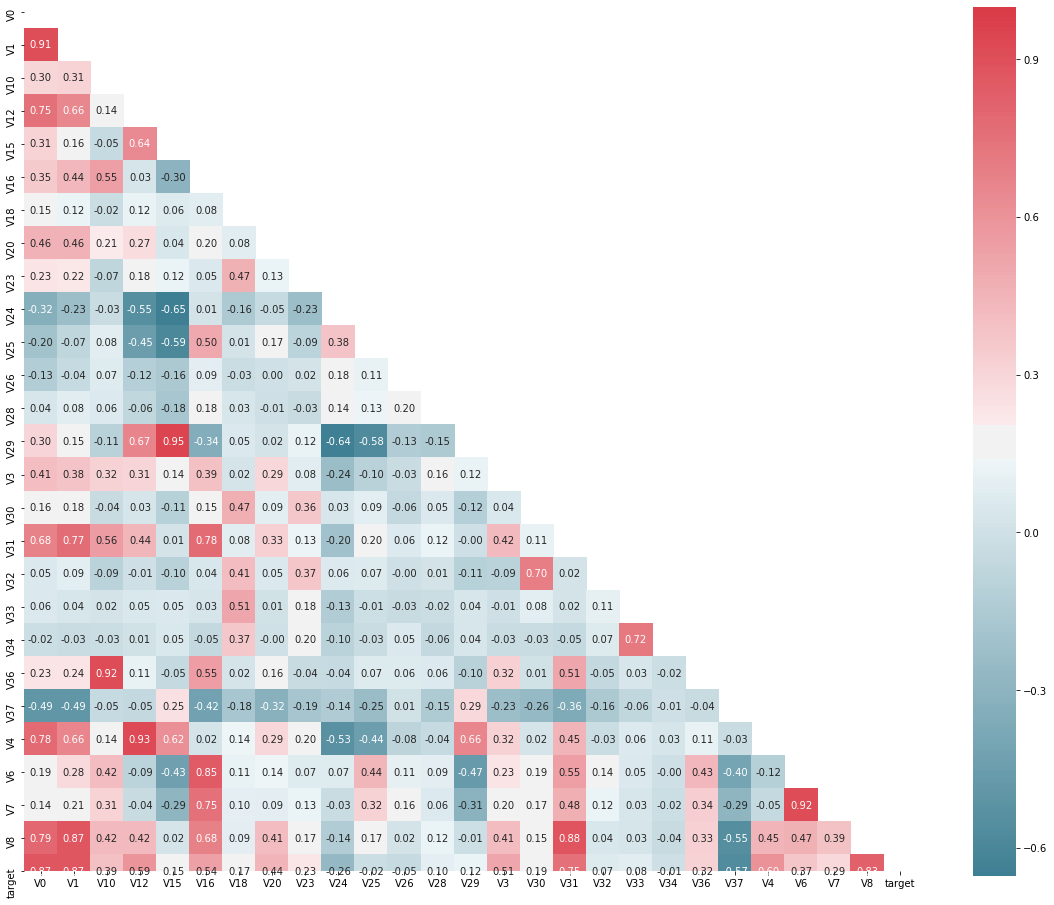

In [8]:
# 找出相关程度
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
colnm = train_data.columns.tolist()  # 列表头
pearson_corr = train_data[colnm].corr(method="pearson")  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
mask = np.zeros_like(pearson_corr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象

g = sns.heatmap(pearson_corr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
plt.show()

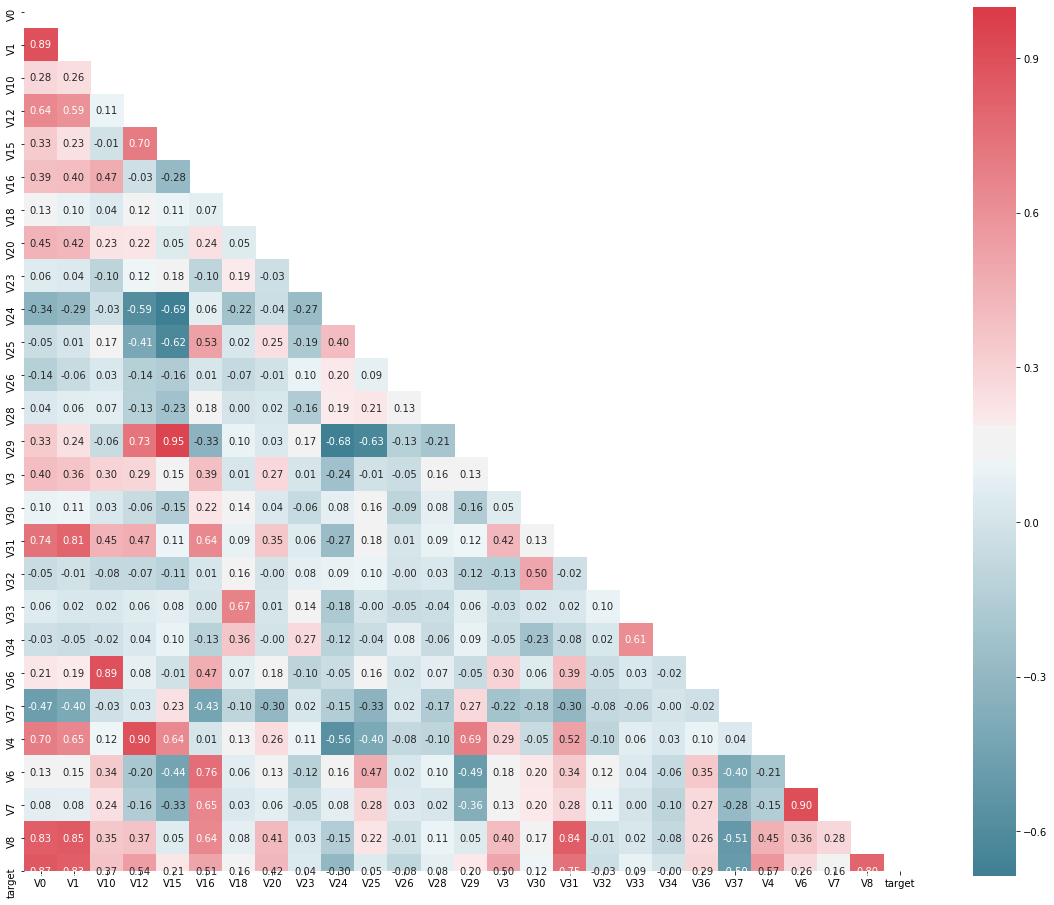

In [9]:
# 找出相关程度
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
colnm = train_data.columns.tolist()  # 列表头
spearman_corr = train_data[colnm].corr(method="spearman")  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
mask = np.zeros_like(spearman_corr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象
g = sns.heatmap(spearman_corr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
plt.show()

In [11]:
s1=spearman_corr['target']
s2=pearson_corr['target']
com_between_corr=pd.merge(left=s1,right=s2,on=s1.index).set_index('key_0').rename(columns={'target_x':'spearman_corr','target_y':'pearson_corr'})
com_between_corr

,spearman_corr,pearson_corr
key_0,,
V0,0.866709,0.873212
V1,0.832457,0.871846
V10,0.371067,0.394767
V12,0.542429,0.594189
V15,0.213490,0.154020
V16,0.510025,0.536748
V18,0.162710,0.170721
V20,0.420424,0.444965
V23,0.043597,0.226331


In [110]:
### 分别根据pearson 和spearman 相关系数去除无用特征
#首先设置阈值为0.1，去除相关性小于0.1的特征
thresholding=0.1
drop_feature_by_spearman=com_between_corr[np.abs(com_between_corr['spearman_corr'])<=thresholding].index
drop_feature_by_pearson=com_between_corr[np.abs(com_between_corr['pearson_corr'])<=thresholding].index
print("spearman:%s"%drop_feature_by_pearson)
print("pearson:%s"%drop_feature_by_spearman)

spearman:Index(['V25', 'V26', 'V32', 'V33', 'V34'], dtype='object', name='key_0')
pearson:Index(['V23', 'V25', 'V26', 'V28', 'V32', 'V33', 'V34'], dtype='object', name='key_0')


In [12]:
def get_drop_feature_by_corr(data,thresholding=0.1,corr_name='spearman'):
    train_data=data[data['type']=='train'].drop(['type'],axis=1)
    corr = train_data[colnm].corr(method=corr_name)  
    s1=corr['target']
    drop_feature=s1[np.abs(s1)<=thresholding].index
    return drop_feature

In [17]:
def get_train_data_drop_corr(data,drop_feature):
    all_data_drop_feature_by_corr=data.drop(labels=drop_feature,axis=1)
    train_data_drop=all_data_drop_feature_by_corr[all_data_drop_feature_by_corr['type']=='train'].drop(labels=['type'],axis=1)
    test_data_drop=all_data_drop_feature_by_corr[all_data_drop_feature_by_corr['type']=='test'].drop(labels=['type','target'],axis=1)
    return all_data_drop_feature_by_corr,train_data_drop,test_data_drop

In [14]:
def result_to_save(re,path):
    y_predict_df=pd.DataFrame(y_predict)
    y_predict_df.to_csv(path,header=False,index=False)

In [115]:
para_dict=[]
for corr_name in ['spearman','pearson']:
    for thresholding in [0.1,0.15,0.2,0.3,0.4,0.6]:
        #设定相关性及阈值获取需要删除的特征
        drop_feature=get_drop_feature_by_corr(all_data_drop_1,thresholding,corr_name)
        train_data_drop,test_data_drop=get_train_data_drop_corr(all_data_drop_1)
        xgb_reg=XGBRegressor(n_estimators=1000,max_depth=8,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
        data=train_data_drop
        y_data=data.iloc[:,-1]
        X_data=data.iloc[:,:-1]
        scores=cross_val_score(xgb_reg,X_data,y_data,scoring='neg_mean_absolute_error',cv=10)
        para_dict.append((corr_name,thresholding,scores))
        print("corr_name:%s\tthresholding:%f\tMAE:%s"%(corr_name,thresholding,np.mean(-scores)))

corr_name:spearman	thresholding:0.100000	MAE:0.2746621261260009
corr_name:spearman	thresholding:0.150000	MAE:0.2756855443600868
corr_name:spearman	thresholding:0.200000	MAE:0.2753941952672937
corr_name:spearman	thresholding:0.300000	MAE:0.2861521362293705
corr_name:spearman	thresholding:0.400000	MAE:0.2947077582560843
corr_name:spearman	thresholding:0.600000	MAE:0.35296037571265554
corr_name:pearson	thresholding:0.100000	MAE:0.27521229267314895
corr_name:pearson	thresholding:0.150000	MAE:0.27514355235852983
corr_name:pearson	thresholding:0.200000	MAE:0.27437968069383306
corr_name:pearson	thresholding:0.300000	MAE:0.27978719397447194
corr_name:pearson	thresholding:0.400000	MAE:0.2947077582560843
corr_name:pearson	thresholding:0.600000	MAE:0.3398400815693006


In [21]:
drop_feature=get_drop_feature_by_corr(all_data_drop_1,0.2,'spearman')
all_data_drop_feature_by_corr,train_data_drop,X_test=get_train_data_drop_corr(all_data_drop_1,drop_feature)
all_data_drop_feature_by_corr.to_csv('./re/all_data_drop_by_corr.txt',header=True,index=False)
xgb_reg=XGBRegressor(max_depth=8,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
y_data=train_data_drop.iloc[:,-1]
X_data=train_data_drop.iloc[:,:-1]
xgb_reg.fit(X_data,y_data)
y_predict=xgb_reg.predict(X_test)
result_to_save(y_predict,'./re/y_predict_1.txt')

### 对数据进行标准化

In [23]:
all_data_drop_by_corr=pd.read_csv('./re/all_data_drop_by_corr.txt')

In [24]:
all_data_drop_by_corr.columns

Index(['V0', 'V1', 'V10', 'V12', 'V15', 'V16', 'V20', 'V24', 'V3', 'V31',
       'V36', 'V37', 'V4', 'V6', 'V8', 'target', 'type'],
      dtype='object')

In [27]:
def min_max_normal(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [29]:
normal_col=all_data_drop_by_corr.columns[:-2]
all_data_drop_by_corr[normal_col]=all_data_drop_by_corr[normal_col].apply(min_max_normal,axis=0)

In [33]:
#保存归一化后的数据
all_data_drop_by_corr.to_csv('./re/all_data_normal.txt',index=False,header=True)

In [54]:
#读取归一化后的数据并进行预测
all_data_normal=pd.read_csv('./re/all_data_normal.txt')
train_data,test_data=get_train_test_data(all_data_normal)
X_train,X_validate,y_train,y_validate=split_train_validate_data(train_data,test_size=0.3,random_state=1)

In [69]:
xgb_reg=XGBRegressor(max_depth=6,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
X_data=train_data.iloc[:,:-1]
y_data=train_data['target']
scores=cross_val_score(xgb_reg,X_data,y_data,cv=10,scoring='neg_mean_absolute_error')
print(-np.mean(scores))

0.27633735508710683


In [71]:
xgb_reg.fit(X_data,y_data)
y_predict=xgb_reg.predict(test_data)
result_to_save(y_predict,'./re/y_predict_1.txt')

成绩从0.1357提高至0.1341

In [242]:
df=pd.read_csv('./re/all_data_normal.txt')

In [243]:
df.describe()

,V0,V1,V10,V12,V15,V16,V20,V24,V3,V31,V36,V37,V4,V6,V8,target
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,2888.000000
mean,0.694172,0.721357,0.348518,0.578507,0.402251,0.679294,0.456147,0.356712,0.603139,0.792709,0.332385,0.545795,0.523743,0.748823,0.715607,0.126353
std,0.144198,0.131443,0.134882,0.105088,0.138561,0.112095,0.134083,0.265512,0.152462,0.102976,0.127456,0.150356,0.106430,0.132560,0.118105,0.983966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.044000
25%,0.626676,0.679416,0.284327,0.532892,0.299016,0.629414,0.370475,0.040616,0.503888,0.761816,0.270584,0.445647,0.478182,0.683324,0.664934,-0.350250
50%,0.729488,0.752497,0.366469,0.591635,0.391437,0.700258,0.447305,0.381736,0.614270,0.815055,0.347056,0.539317,0.535866,0.774125,0.742884,0.313000
75%,0.790195,0.799553,0.432965,0.641971,0.489954,0.753279,0.522660,0.574728,0.710474,0.852229,0.414861,0.643061,0.585036,0.842259,0.790835,0.793250
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.538000


### BOX-COX transform

In [135]:
all_data_normal=pd.read_csv('./re/all_data_normal.txt')
cols_numeric=all_data_normal.columns

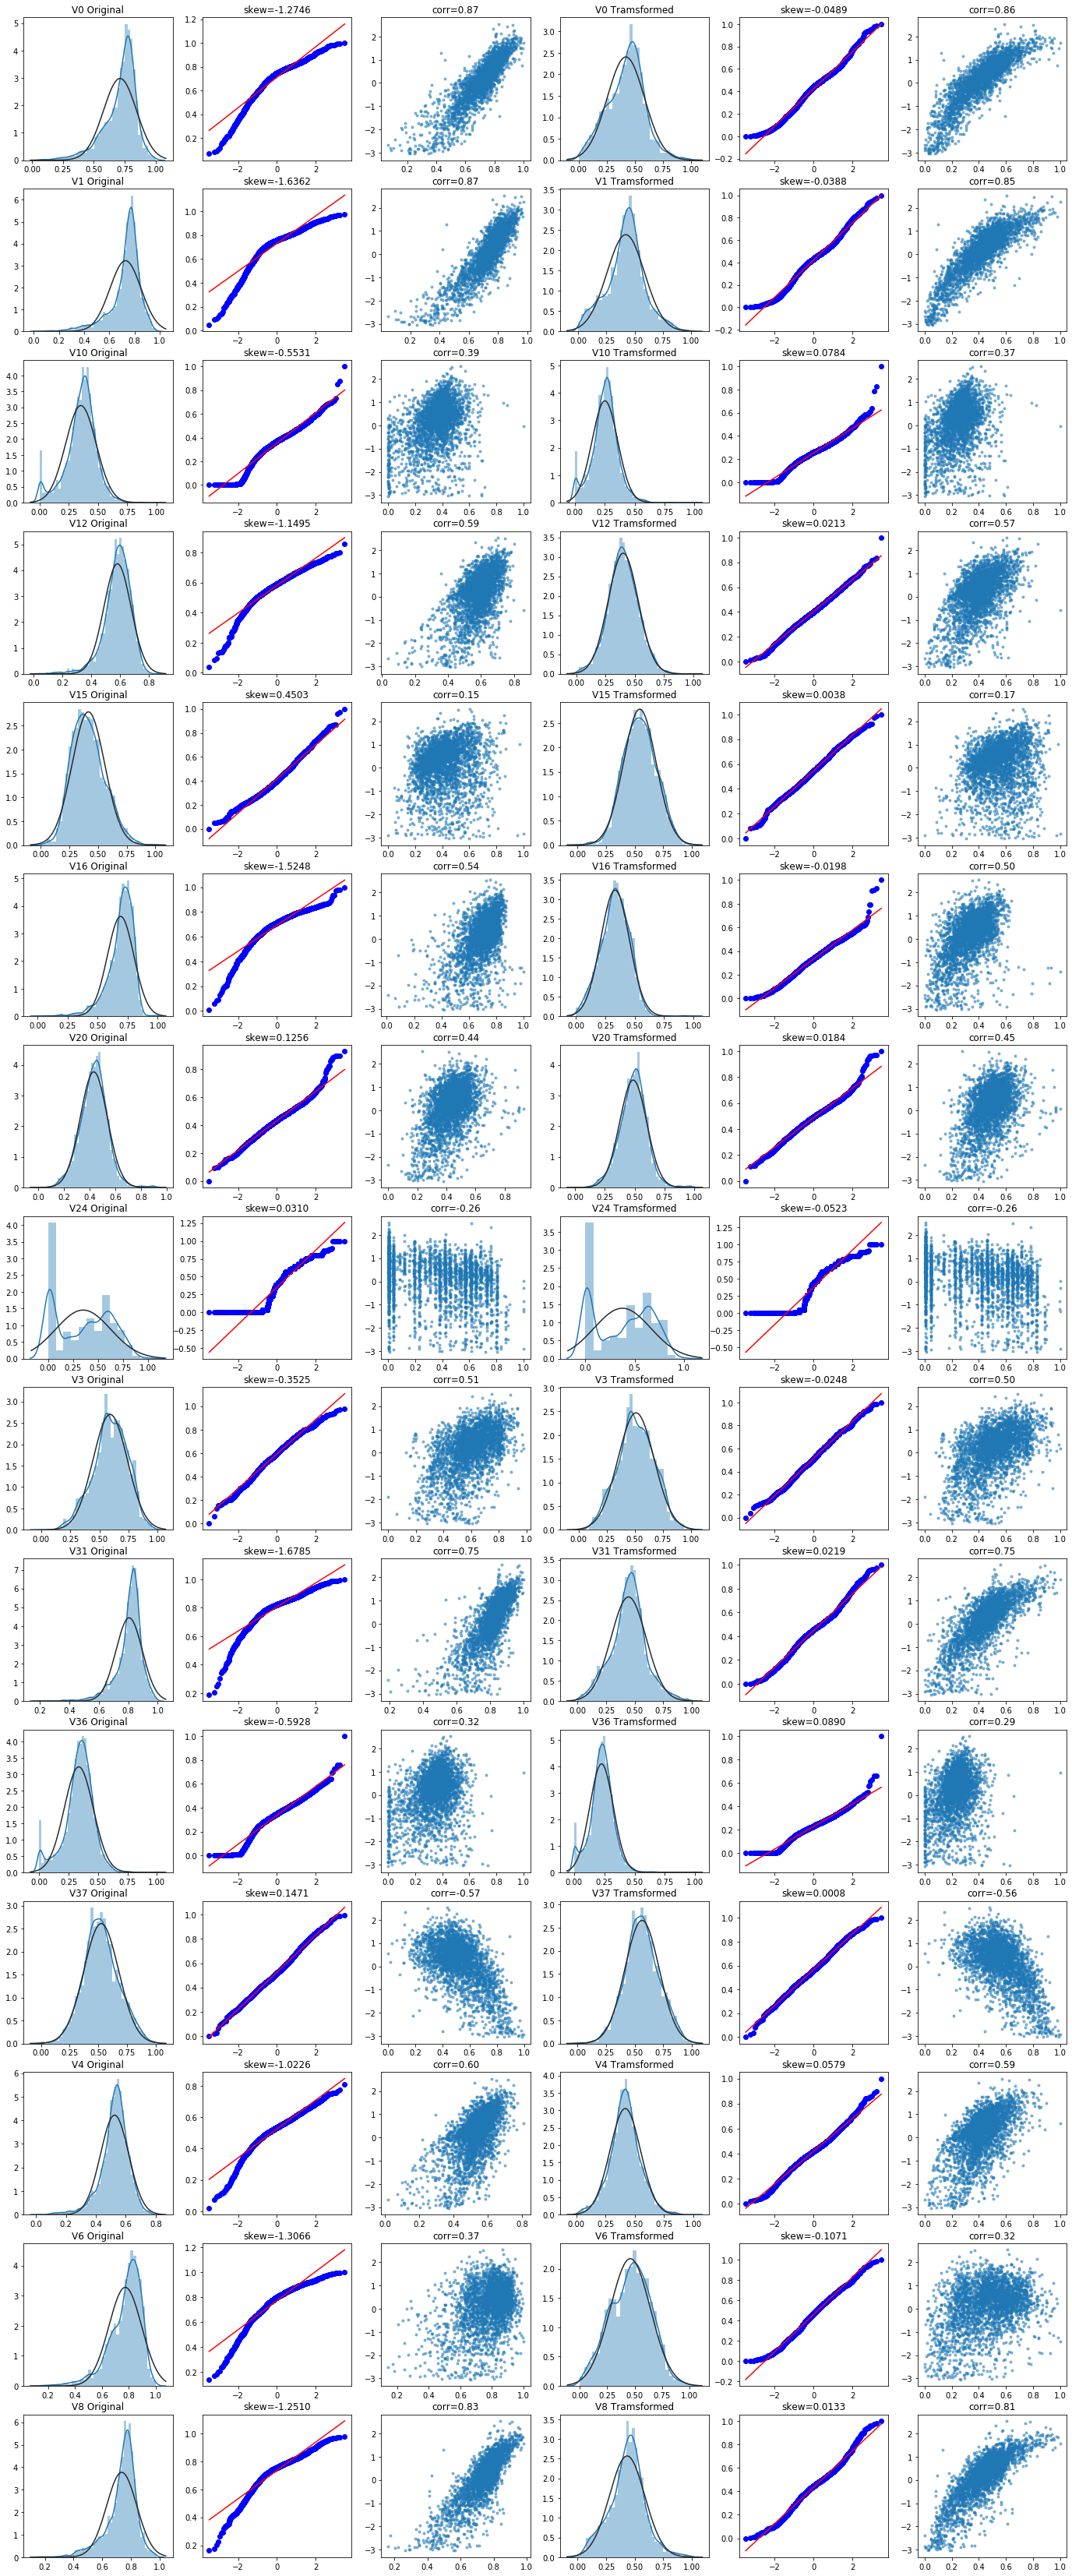

In [136]:
fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target' and var !='type':
        dat = all_data_normal[[var, 'target']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var],fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
        
       
        """
        boxcox:
           y = (x**lmbda - 1) / lmbda,  for lmbda > 0
               log(x),                  for lmbda = 0
        """
     
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = min_max_normal(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

In [137]:
#进行box-cox变换
for feature in cols_numeric[:-2]:
    all_data_normal[feature],_=stats.boxcox(all_data_normal[feature]+1)

In [138]:
#保存box-cox变换后的结果
all_data_normal.to_csv("./re/all_data_box_cox.txt",index=False,header=True)

In [139]:
all_data_box_cox=pd.read_csv('./re/all_data_box_cox.txt')
train_data,test_data=get_train_test_data(all_data_box_cox)
X_train,X_validate,y_train,y_validate=split_train_validate_data(train_data,test_size=0.3,random_state=1)

In [140]:
xgb_reg=XGBRegressor(max_depth=6,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
X_data=train_data.iloc[:,:-1]
y_data=train_data['target']
scores=cross_val_score(xgb_reg,X_data,y_data,cv=10,scoring='neg_mean_absolute_error')
print(-np.mean(scores))

0.27683245096797787


In [123]:
xgb_reg.fit(X_data,y_data)
y_predict=xgb_reg.predict(test_data)
result_to_save(y_predict,'./re/y_predict_1.txt')

结论 对特征做box-cox变换后 分数从0.1341降为0.1342

### 对box-cox后的特征进行标准化处理

In [145]:
all_data_box_cox=pd.read_csv('./re/all_data_box_cox.txt')
normal_col=all_data_box_cox.columns[:-2]
all_data_box_cox[normal_col]=all_data_box_cox[normal_col].apply(min_max_normal,axis=0)
all_data_box_cox.to_csv('./re/all_data_box_cox_normal.txt',header=True,index=False)

In [146]:
all_data_box_cox_normal=pd.read_csv('./re/all_data_box_cox_normal.txt')
train_data,test_data=get_train_test_data(all_data_box_cox_normal)
X_train,X_validate,y_train,y_validate=split_train_validate_data(train_data,test_size=0.3,random_state=1)

In [149]:
xgb_reg=XGBRegressor(max_depth=6,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
X_data=train_data.iloc[:,:-1]
y_data=train_data['target']
scores=cross_val_score(xgb_reg,X_data,y_data,cv=10,scoring='neg_mean_absolute_error')
print(-np.mean(scores))

0.27785737788916


In [150]:
xgb_reg.fit(X_data,y_data)
y_predict=xgb_reg.predict(test_data)
result_to_save(y_predict,'./re/y_predict_1.txt')

结论：对box-cox后的特征进行归一化后 预测准确度略有下降 从0.1342下降至0.1346

### 使用box-cox转化后的特征，通过xgb训练筛选出离群数据

In [201]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)
def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)
mse_score=make_scorer(mse,greater_is_better=False)

In [161]:
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

In [156]:
from sklearn.linear_model import Ridge

In [ ]:
R2= 0.9485160462081639
rmse= 0.2203601107442791
mse= 0.04855857840723092
---------------------------------------
mean of residuals: -0.002890877984172933
std of residuals: 0.22039568052640574
---------------------------------------

R2= 0.9485160462081639
rmse= 0.2203601107442791
mse= 0.04855857840723092
---------------------------------------
mean of residuals: -0.002890877984172933
std of residuals: 0.22039568052640574
---------------------------------------
17 outliers:
[1584, 2211, 2667, 805, 2264, 1086, 2668, 2807, 777, 1704, 2279, 1458, 1523, 1979, 1874, 2842, 2669]


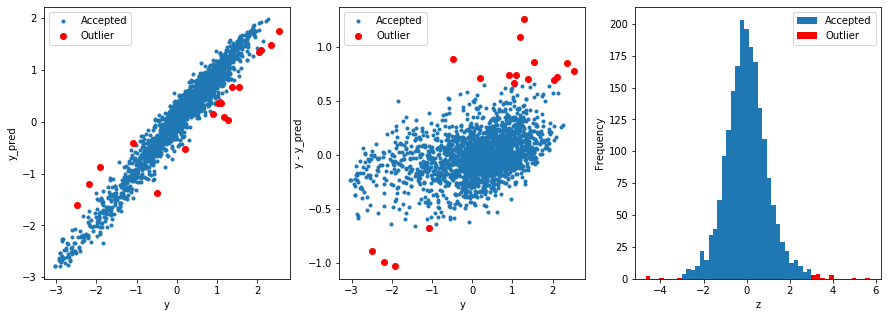

In [204]:
all_data_box_cox=pd.read_csv('./re/all_data_box_cox.txt')
train_data,test_data=get_train_test_data(all_data_box_cox)
X_train,X_validate,y_train,y_validate=split_train_validate_data(train_data,test_size=0.3,random_state=1)
xgb_reg=XGBRegressor(max_depth=6,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
outliers = find_outliers(xgb_reg, X_train, y_train)

In [205]:
all_data_drop_out_data=all_data_box_cox.drop(labels=outliers)
all_data_drop_out_data.to_csv('./re/all_data_drop_out_data.txt',header=True,index=False)

In [206]:
train_data,test_data=get_train_test_data(all_data_drop_out_data)
X_train,X_validate,y_train,y_validate=split_train_validate_data(train_data,test_size=0.3,random_state=1)

In [180]:
from sklearn import metrics

In [207]:
xgb_reg=XGBRegressor(max_depth=6,min_child_weight=5,eta=0.05, gamma=0.025,colsample_bytree= 0.6,subsample=0.7)
X_data=train_data.iloc[:,:-1]
y_data=train_data['target']
scores=cross_val_score(xgb_reg,X_data,y_data,cv=10,scoring='neg_mean_squared_error')
print(-np.mean(scores))

0.1270127481731754


In [176]:
xgb_reg.fit(X_data,y_data)
y_predict=xgb_reg.predict(test_data)
result_to_save(y_predict,'./re/y_predict_1.txt')

总结：通过xgb筛选出离群数据，score从0.1342提高到0.1336

### 对xgb进行调参

In [194]:
all_data_drop_out_data=pd.read_csv('./re/all_data_drop_out_data.txt')
train_data,test_data=get_train_test_data(all_data_drop_out_data)
X_data=train_data.iloc[:,:-1]
y_data=train_data['target']

In [231]:
xgb_reg=XGBRegressor(booster='gbtree',max_depth=8,
                     min_child_weight=5,eta=0.05, 
                     gamma=0.025,colsample_bytree= 0.7,
                     subsample=0.1,reg_lambda=0.5,
                     reg_alpha=0,learning_rate=0.009,
                     n_estimators=1000)
grid_param={"max_depth":[6,7,8],
           "subsample":[0.1],
           "colsample_bytree":[0.7],
           "n_estimators":[1000],
           "learning_rate":[0.009],
           "reg_lambda":[0.5,0.8,1,2],
           "reg_alpha":[0.5,0,8,1,2]}
grid_model=GridSearchCV(xgb_reg,grid_param,scoring=mse_scorer,cv=5)
grid_model.fit(X_data,y_data)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    eta=0.05, gamma=0.025, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=7, min_child_weight=5,
                                    missing=nan, monotone_co...
                                    validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.009],
                         'max_depth': [6, 7, 8], 'n_estimators': [1000],
                         'reg_alpha': [0.5, 0, 8, 1, 2],
   

In [232]:
print(grid_model.best_params_)
print(grid_model.best_score_)
print(grid_model.best_estimator_)

{'colsample_bytree': 0.7, 'learning_rate': 0.009, 'max_depth': 8, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.1}
-0.11964412037637691
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.05, gamma=0.025,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.009, max_delta_step=0, max_depth=8,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=0.5, scale_pos_weight=1, subsample=0.1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [240]:
xgb_reg=XGBRegressor(booster='gbtree',max_depth=8,
                     min_child_weight=5,eta=0.05, 
                     gamma=0.025,colsample_bytree= 0.7,
                     subsample=0.1,reg_lambda=0.5,
                     reg_alpha=0,learning_rate=0.009,
                     n_estimators=1000)
X_data=train_data.iloc[:,:-1]
y_data=train_data['target']
scores=cross_val_score(xgb_reg,X_data,y_data,cv=10,scoring='neg_mean_squared_error')
print(-np.mean(scores))

0.11965196325517706


In [241]:
xgb_reg.fit(X_data,y_data)
y_predict=xgb_reg.predict(test_data)
result_to_save(y_predict,'./re/y_predict_1.txt')

结论：经过对xgb调参score从0.1336提高到0.1251